# PA005: High Value Customer Identification

# 0.0. Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0. Imports

In [60]:
import numpy   as np
import pandas  as pd
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [16, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [3]:
!cd

C:\Users\Arbo\repos\my_git\insiders_clustering\notebooks


In [4]:
# load data
df_raw = pd.read_csv( r'..\data\raw\Ecommerce.csv', encoding= 'unicode_escape')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

# <font color='black'> 1.0. Descrição dos dados </font>

In [5]:
df1 = df_raw.copy()

## 1.1. Rename columuns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
             'unit_price', 'customer_id', 'country']

In [7]:
df1.columns = cols_new

## 1.2. Data dimensions

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

Attributes Desciption

* invoice_no   -> número referente a transação do cliente, valor único para cada transação

* stock_code   -> código do item

* description  -> descrição do item

* quatity      -> quantidade de cada item por transação

* invoice_date -> data que a transação foi gerada

* unit_price   -> preço unitário do produto

* customer_id  -> ID do ciente

* country      -> localizaão do cliente 

In [9]:
df1.head(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.00,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00,29-Nov-16,2.75,17850.00,United Kingdom


In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity        float64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isnull().sum()

invoice_no           0
stock_code        6035
description       7489
quantity          6035
invoice_date      6035
unit_price        6035
customer_id     138727
country           6035
dtype: int64

## 1.5. Replace NA

In [12]:
df1 = df1.dropna(subset=['description','customer_id'])

print('Removed data: {:.2f}'.format(1-(df1.shape[0]/df_raw.shape[0])))

Removed data: 0.26


In [13]:
df1.shape

(403182, 8)

In [14]:
df1.isnull().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change dtypes

In [15]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity        float64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [16]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y') #format é o formato origiral que está no dataset, para sim a função realizar a formatação

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')

In [17]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.00,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00,2016-11-29,3.39,17850,United Kingdom


## 1.7. Descriptive Statistics

Realização desta etapa em outro momento do ciclo. Pois o objetivo é rodar o modelo, antes de análisar os dados.

# <font color='black'> 2.0. Feature Engineering </font>

In [42]:
df2 = df1.copy()

## 2.1. Feature Creation

Criação das variáveis base, em relação ao modelo RFM utilizado com Benchmark para o projeto.

In [43]:
# data reference - tabela para chaves primarias

df_ref = df2.drop(['invoice_no','stock_code','description','quantity',
                   'invoice_date','unit_price','country'], axis=1).drop_duplicates(ignore_index = True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [44]:
#gross revenue - quantity * price (faturamento)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

#Monetary
df_monetary = df2[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

#recency - last date invoice by customer - today
df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

#frequency
df_frequency = df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')

#avg_ticket
df_avg_tkt = df2[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_tkt, on='customer_id', how='left')

In [46]:
df_ref.isnull().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

# <font color='red'> 3.0. Filtragem de Varivéis </font>

In [47]:
df3 = df_ref.copy()

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [48]:
df4 = df3.copy()

# <font color='red'> 5.0. Data Preparation </font>

In [49]:
df5 = df4.copy()

# <font color='red'> 6.0. Feature Selection </font>

In [50]:
df6 = df5.copy()
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.95
1,13047,2985.50,31,18,15.71
2,12583,7187.34,2,18,28.63
3,13748,948.25,95,5,33.87
4,15100,635.10,330,6,105.85


# <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [51]:
X = df6.drop(columns=['customer_id'])

In [72]:
clusters = [2, 3, 4, 5, 6, 7]

## <font color='black'> 7.1. Within-Cluster Sum of Square (WSS) </font>

Métrica que verifica as distâncias entre os pontos dos clusters. Verifica a compreesão dos pontos entre clusters.

O cluster adequado, seria o cluster com maior variação entre o resultado dos clusters. Soma da distância entre os pontos de um mesmo clusters, em relação ao centroide, ou seja, quanto menor, melhor é o agrupamento.

O centroide pode ser um valor, ou uma média entre os pontos.

Melhor seleção de cluster, é quando os clusters são condensados e distântes entre si.

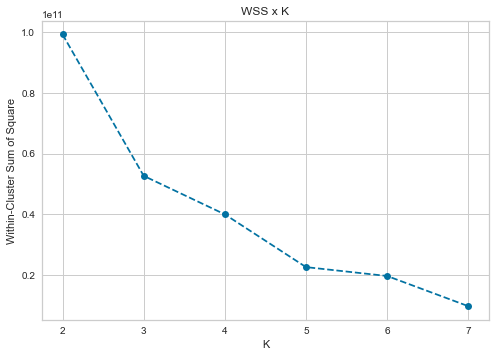

In [55]:
wss = []

for k in clusters:
    #model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42) # radom = iniciar por centroides aleatórios, n_init = diminuir o vies da seleção, 

    #model training
    kmeans.fit(X)

    #validation
    wss.append(kmeans.inertia_)
    
#plot wss - Elbow methods
plt.plot(clusters, wss, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS x K');

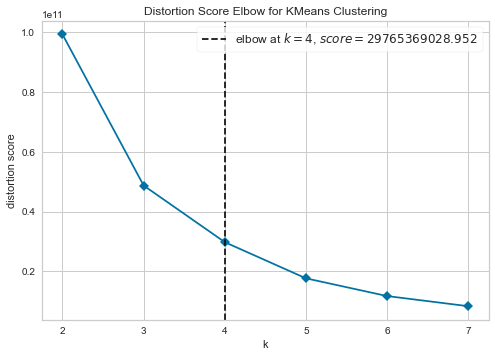

In [56]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False )
kmeans.fit(X)
kmeans.show();

In [57]:
wss

[99217249271.70027,
 52664532176.16276,
 39988201121.02734,
 22631319620.255577,
 19707861331.0846,
 9764623325.930155]

## <font color='black'> 7.2. Silhouette Score </font>

Silhouette Score - Verifica a distância dos clusters

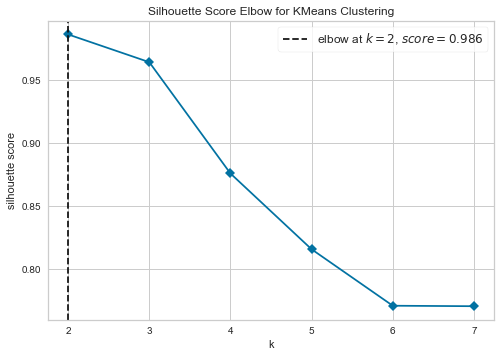

In [58]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show();

## 7.1. Silhouette Analysis

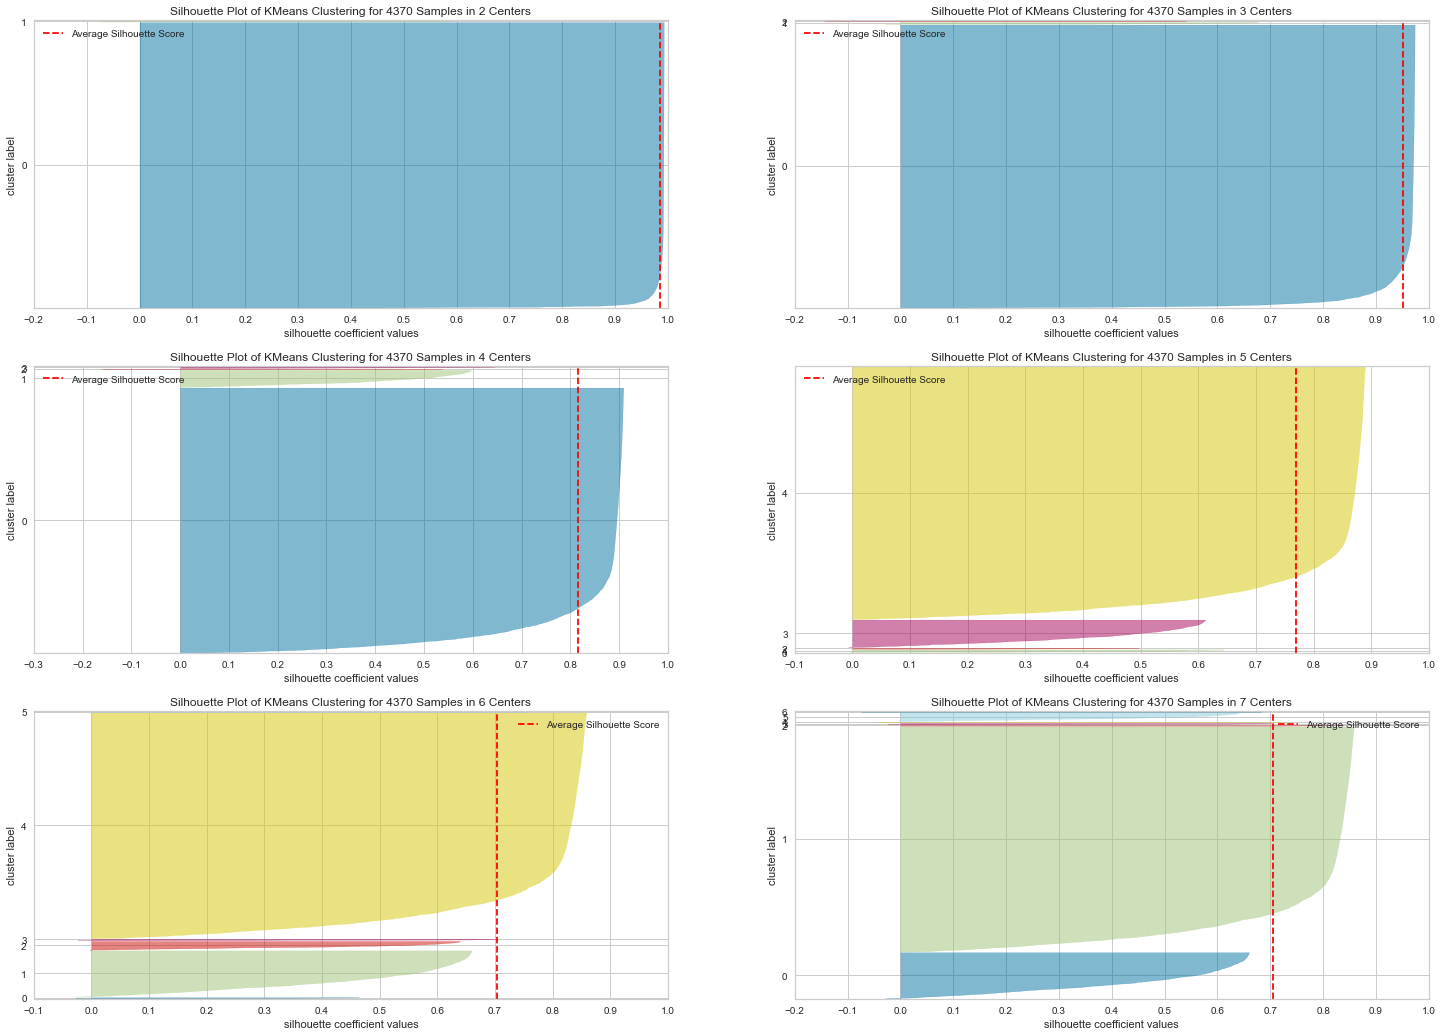

In [86]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

# <font color='red'> 8.0. Model Training </font>

## 8.1. K-Means

In [87]:
#model definition
k=4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2. Cluster Validation

In [88]:
# WSS
print('WSS value: {}'.format(kmeans.inertia_))

# SS
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 39988201121.027336
SS value: 0.8153394652769199


# <font color='red'> 9.0. Cluster Analysis </font>

In [89]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.95,1
1,13047,2985.50,31,18,15.71,0
2,12583,7187.34,2,18,28.63,1
3,13748,948.25,95,5,33.87,0
4,15100,635.10,330,6,105.85,0


## <font color='black'> 9.1. Visualization Inspection </font>

C:\Users\Arbo\anaconda3\envs\pa0005_insiders_clustering\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



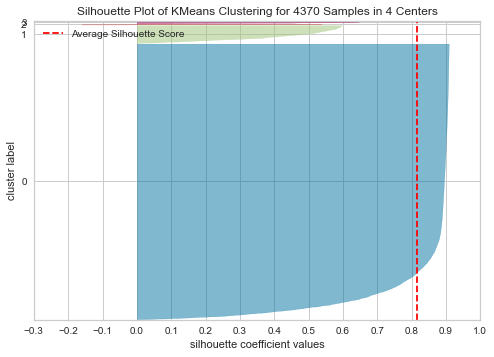

In [100]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

## 9.2. 2D Plot

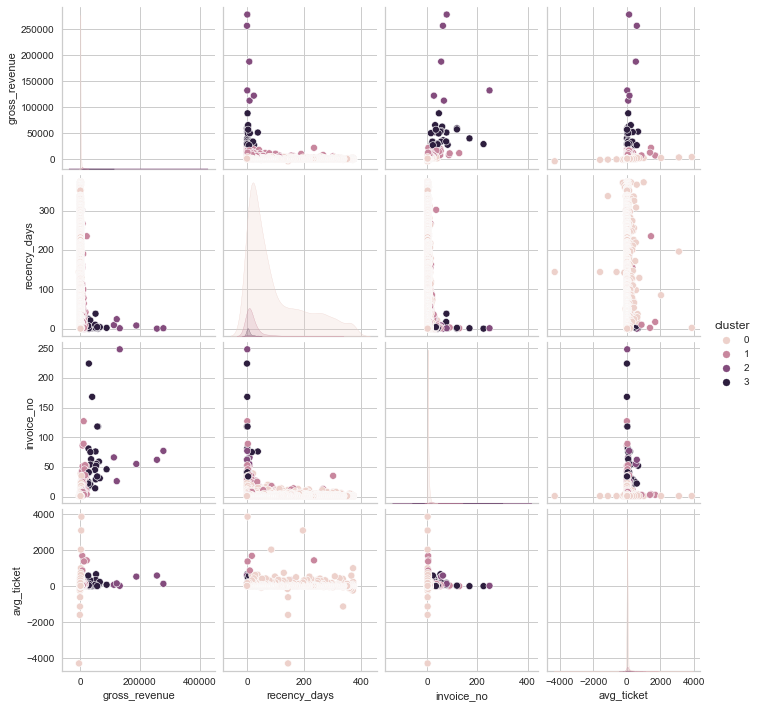

In [102]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster');

## 9.3. UMAP

In [104]:
import umap.umap_ as umap

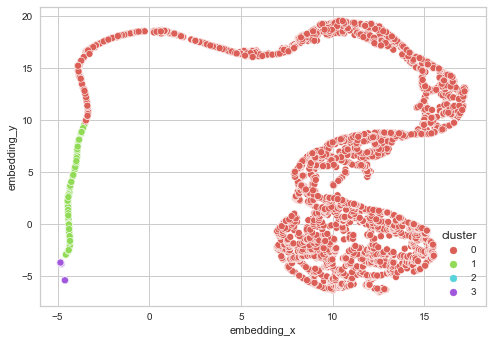

In [107]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X) #embedding, espaço projetado. Saindo do min para o max, ou ao contrário. 2D to 9D or 9D to 2D

#embedding

df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

In [93]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

## 9.2. Cluster Profile

In [96]:
#Number of customer
df9_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df9_cluster['percentage'] = 100*(df9_cluster['customer_id'] / df9_cluster['customer_id'].sum())

#Avg Gross Revenue
df_avg_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_revenue, how='inner', on='cluster')

#Avg Recency Days
df_avg_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_days, how='inner', on='cluster')

#Avg Frequency
df_avg_freq = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_freq, how='inner', on='cluster')

#Avg Frequency
df_avg_tkt = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_tkt, how='inner', on='cluster')

In [97]:
df9_cluster

,cluster,customer_id,percentage,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4074,93.23,945.90,96.92,3.66,25.37
1,1,263,6.02,8158.17,20.29,19.61,63.84
2,2,6,0.14,181395.49,7.17,89.00,253.48
3,3,27,0.62,42947.16,6.41,58.30,164.64


### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 6 (0.14% do customers )
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $181.395,49 dólares
        
### Cluster 02: 
    - Número de customers: 29 (0.66 do customers )
    - Recência em média: 14 dias
    - Compras em média: 55 compras
    - Receita em média: $41.563,71 dólares
        
### Cluster 03: 
    - Número de customers: 4.335 (99% do customers )
    - Recência em média: 92 dias
    - Compras em média: 4 compras
    - Receita em média: $1.373,34 dólares

# <font color='red'> 10.0. Deploy To Production </font>